# Download Data

In [1]:
import os
import sys
root_dir = os.path.split(os.getcwd())[0]
src_dir = os.path.join(root_dir, "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)
os.chdir(root_dir)

Execute `make data` or this cell first to import data.

In [2]:
from data.make_dataset import download_dataset, create_hdf

download_dataset()
create_hdf()

# Import Data

In [3]:
import pandas as pd

df = pd.read_hdf('./data/processed/train.hdf', key='data')

We select a subset of the data. Also, id3=610 is way too often, let's drop it.

In [4]:
#df = df[~(df["id3"] == 610)].sample(frac=.1)
df = df[df["user_id"] < 10000]

In [5]:
minDay = df["date"].min()
maxDay = df["date"].max()
print(minDay, maxDay)

1 54


In [6]:
df[:5]

,id3,user_id,id2,date,id1
32,477,5372,29,1,2
39,543,5372,42,1,2
332,541,6947,108,1,4
433,468,5372,61,1,3
515,731,5372,83,1,5


In [7]:
df.count()

id3        429952
user_id    429952
id2        429952
date       429952
id1        429952
dtype: int64

# Train-Test-Split

In [8]:
train = df[df["date"] <= maxDay - 7]
test = df[df["date"] > maxDay - 7]

In [9]:
print(train["id1"].count(), test["id1"].count())

399908 30044


In [10]:
minDayTest = test["date"].min()
maxDayTest = test["date"].max()
print(minDayTest, maxDayTest)

48 54


In [11]:
minDayTrain = train["date"].min()
maxDayTrain = train["date"].max()
print(minDayTrain, maxDayTrain)

1 47


# Create Hash Maps

In [12]:
def parentIds(df):
    id32 = df.groupby(["id3"])["id2"].max().to_dict()
    id21 = df.groupby(["id2"])["id1"].max().to_dict()
    return id21, id32

In [13]:
id21, id32 = parentIds(train[:10])
print(id21, id32)

{16: 9, 96: 8, 66: 12, 83: 5, 4: 10, 9: 4, 42: 2, 108: 4, 29: 2, 61: 3} {434: 96, 731: 83, 468: 61, 875: 4, 233: 9, 543: 42, 541: 108, 477: 29, 910: 16, 111: 66}


In [14]:
id21, id32 = parentIds(train)
print(len(id21), len(id32))

122 903


In [15]:
def userIds(df):
    userToId3 = df.groupby(["user_id"])["id3"].apply(lambda x: list(set(x))).to_dict()
    id3ToUser = {i: [] for i in id32}
    for user, tid3s in userToId3.items():
        for i in tid3s:
            id3ToUser[i].append(user)
    return userToId3, id3ToUser

In [16]:
userToId3, id3ToUser = userIds(train[:10])
print(userToId3)

{3404: [875], 1826: [111], 6947: [541], 2820: [434], 5372: [233, 910, 468, 731, 477, 543]}


In [17]:
userToId3, id3ToUser = userIds(train)
print(len(userToId3), len(id3ToUser))

8451 903


In [18]:
def userVisits(df):
    userId3Visits = df.groupby(["user_id", "date"])["id3"].apply(lambda x: list(set(x))).to_dict()
    return userId3Visits

In [19]:
userId3Visits = userVisits(train[:10])
print(userId3Visits)

{(3404, 1): [875], (5372, 1): [233, 910, 468, 731, 477, 543], (2820, 1): [434], (6947, 1): [541], (1826, 1): [111]}


In [20]:
userId3Visits = userVisits(train)
print(len(userId3Visits))

64183


In [21]:
id3Visits = train["id3"].value_counts().to_dict()
id3s = sorted(train["id3"].unique(), key=lambda i: -id3Visits[i])
print(len(id3s))

903


In [22]:
#print(id3s, id3Visits)

# Fix one Id3, look at the distribution of visits before

In [23]:
def profile(user, day, duration=7, sums=False):
    id3Visited = []
    for d in range(max(0, day - duration), day):
        if (user, d) in userId3Visits:
            id3Visited += userId3Visits[(user, d)]
    return [id3Visited.count(i) for i in id3s] + ([len(id3Visited)] if sums else [])

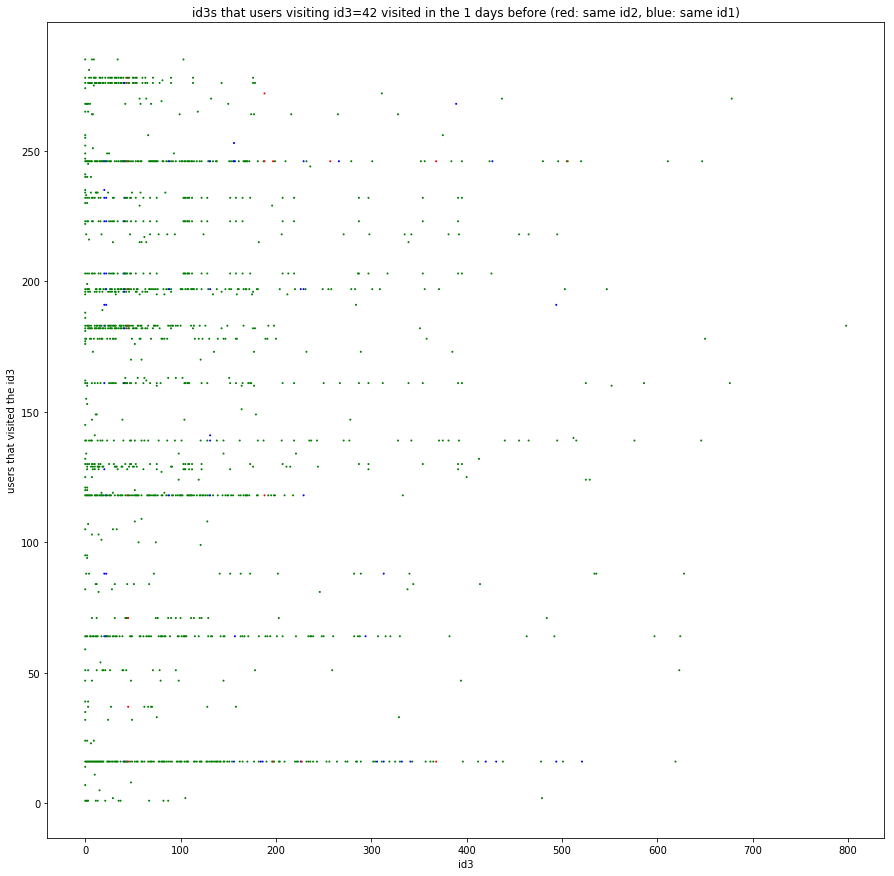

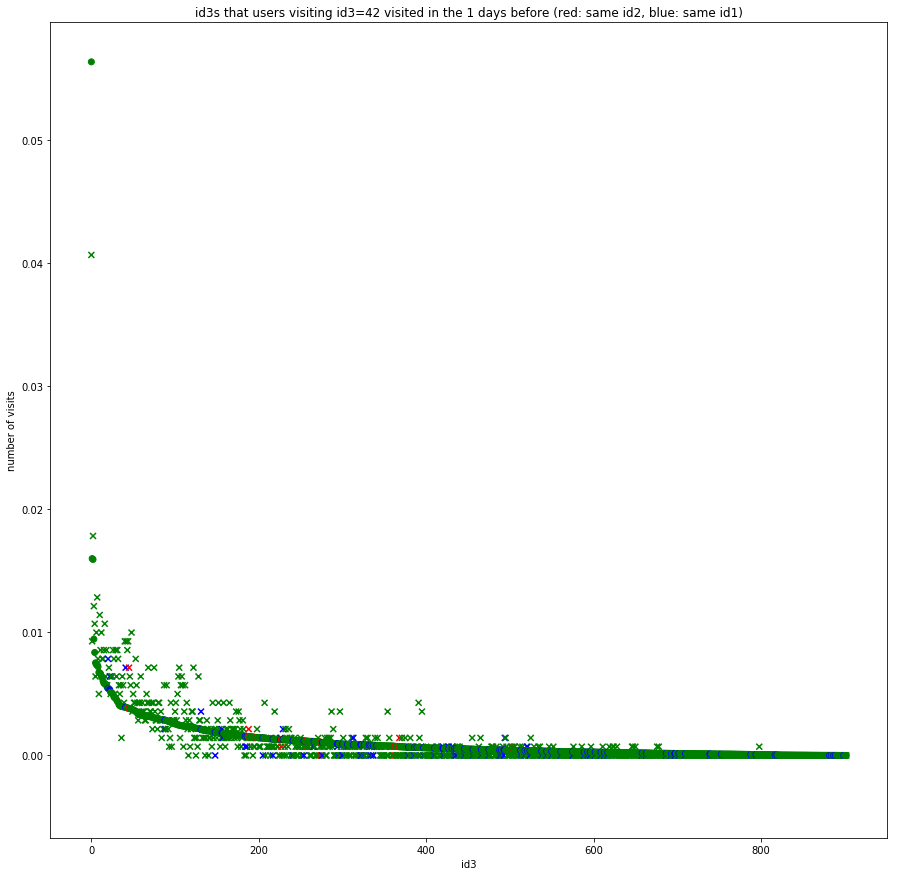

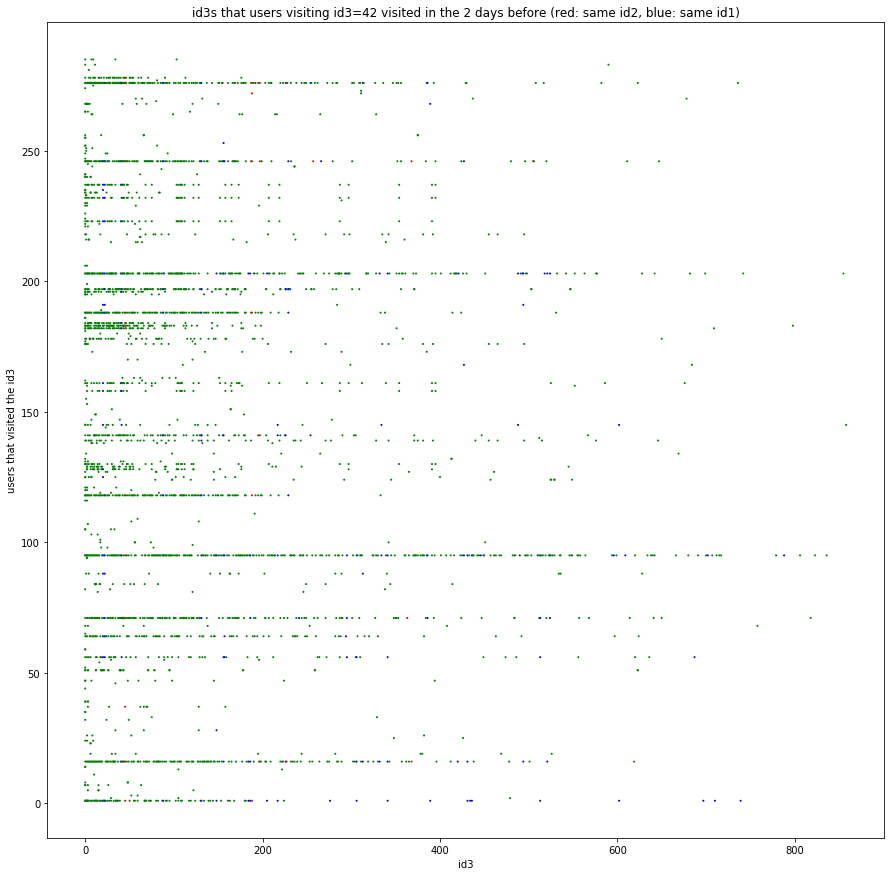

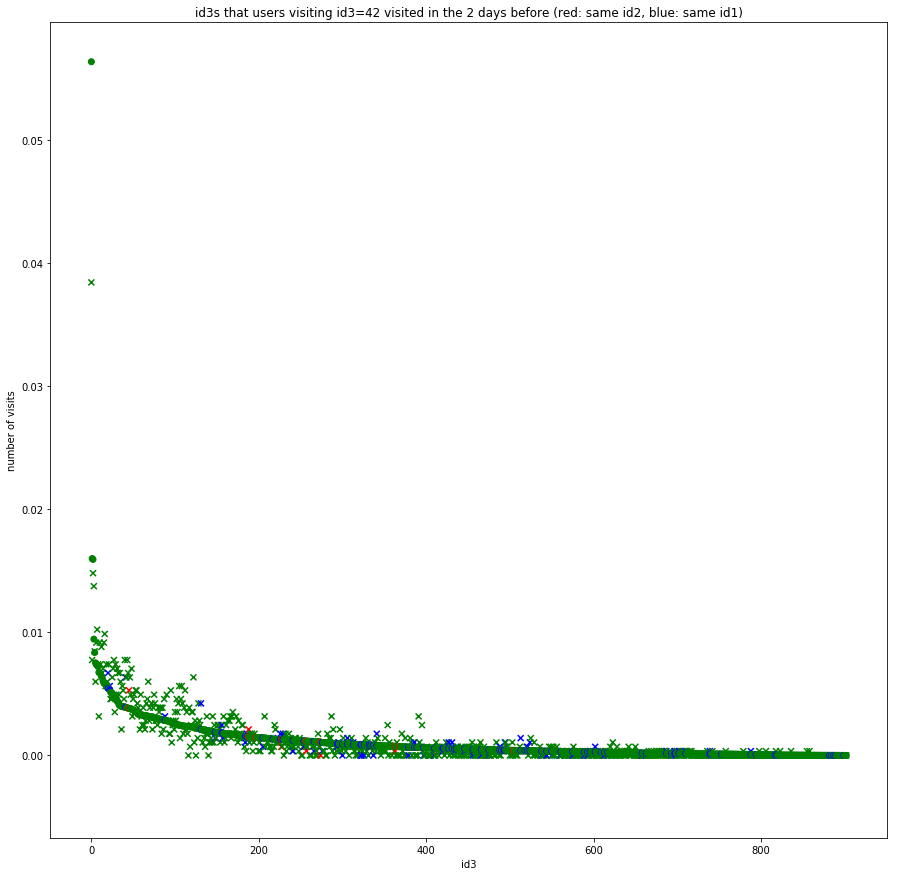

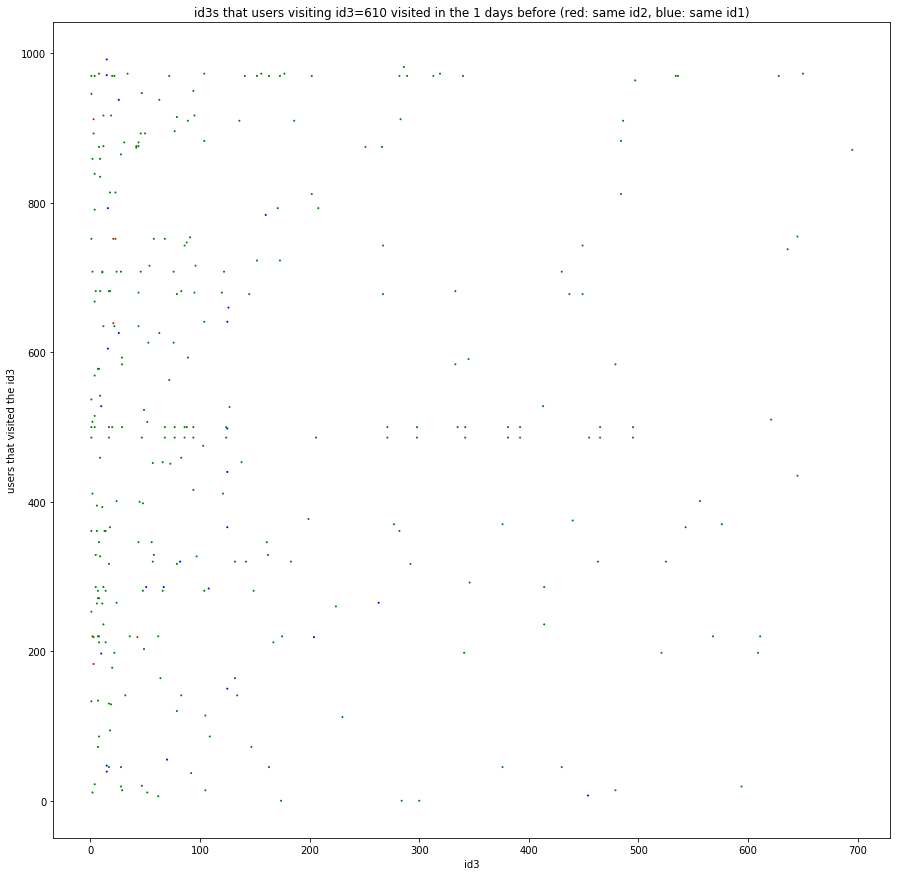

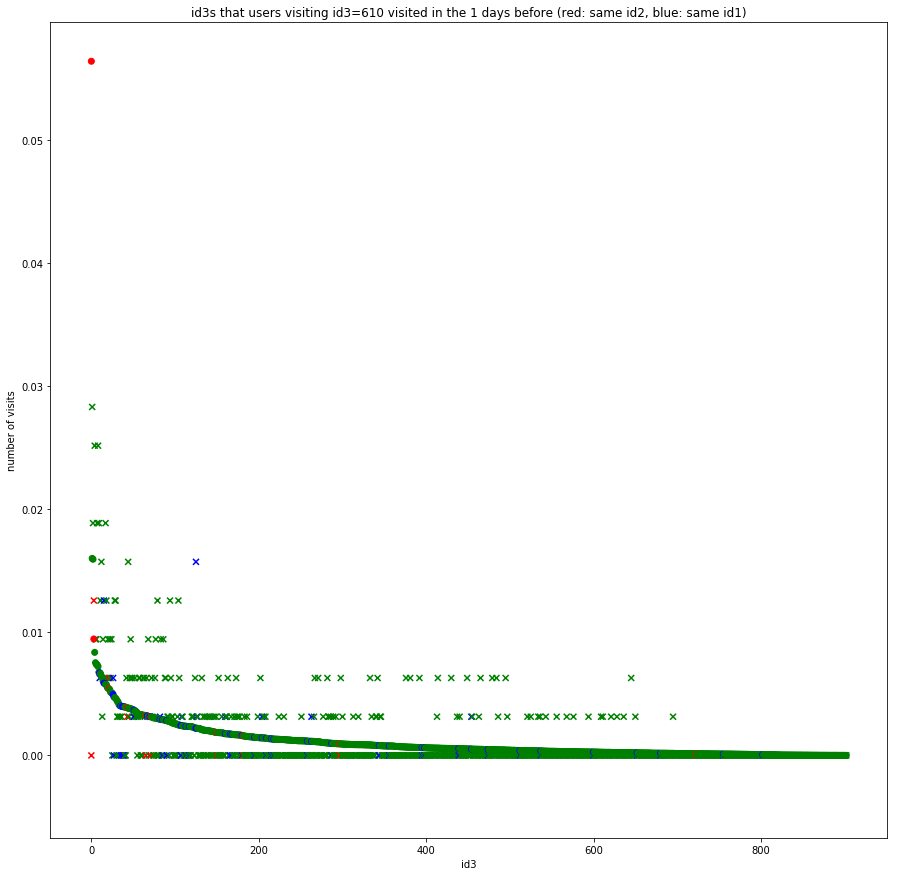

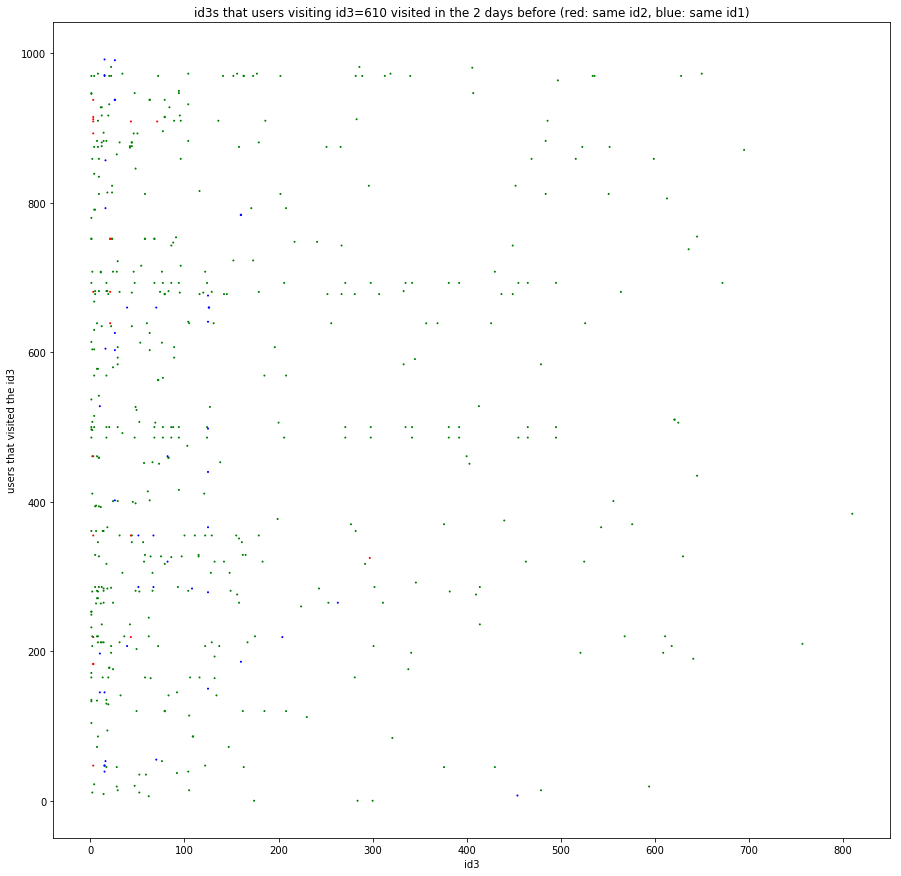

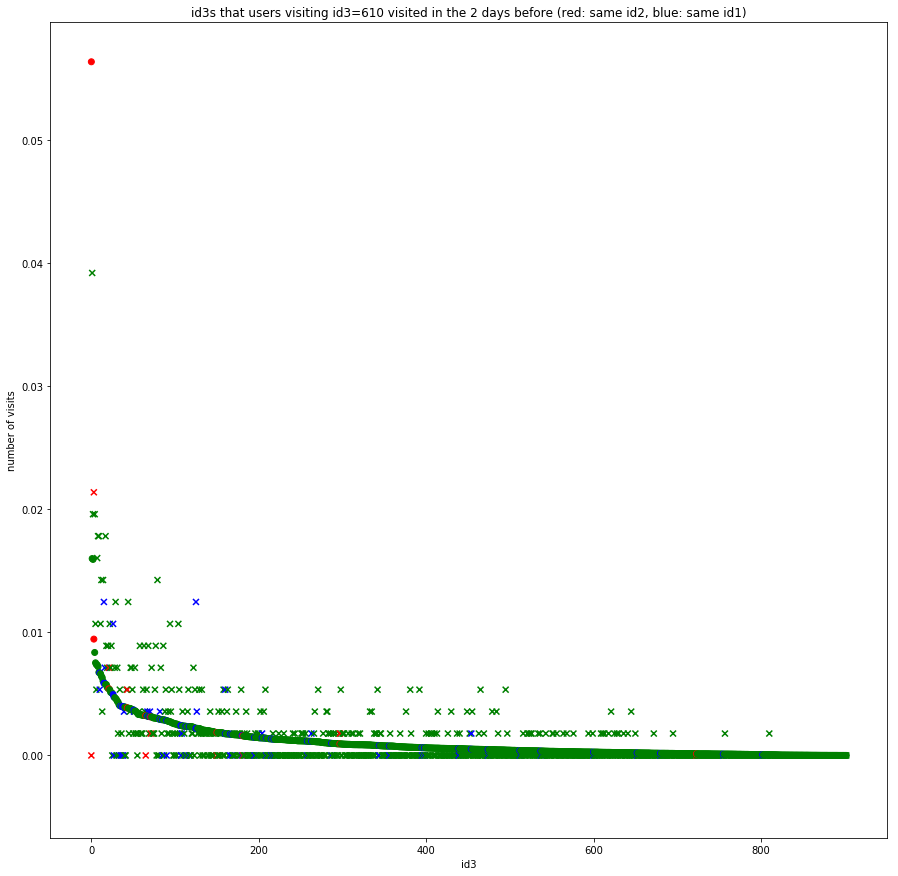

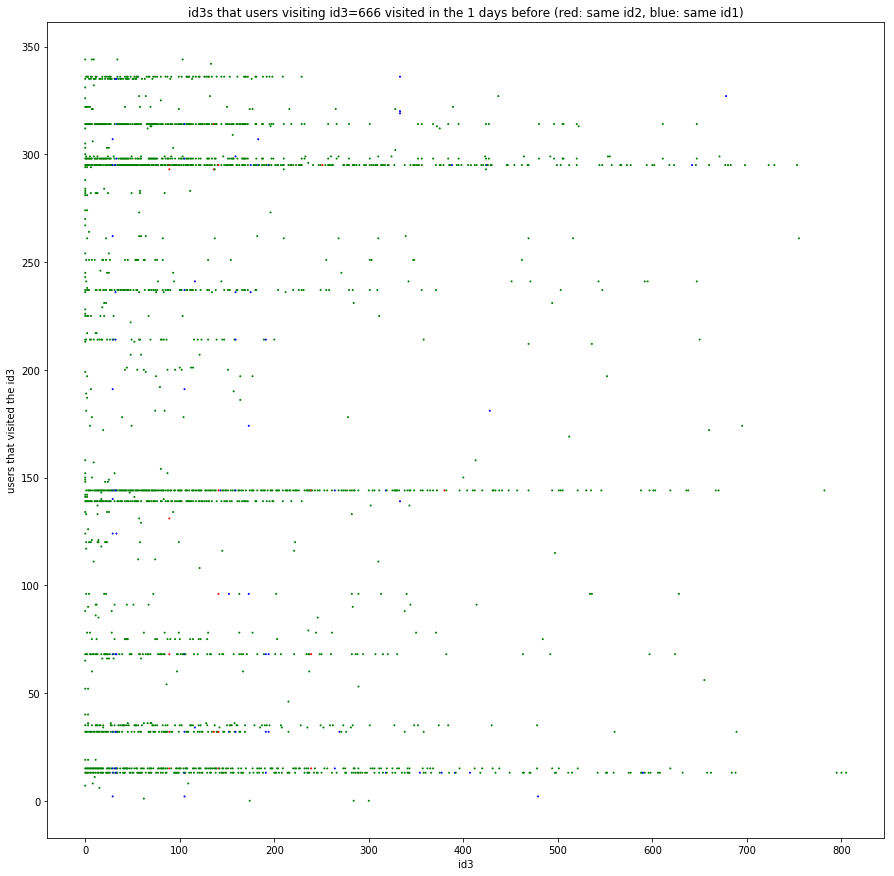

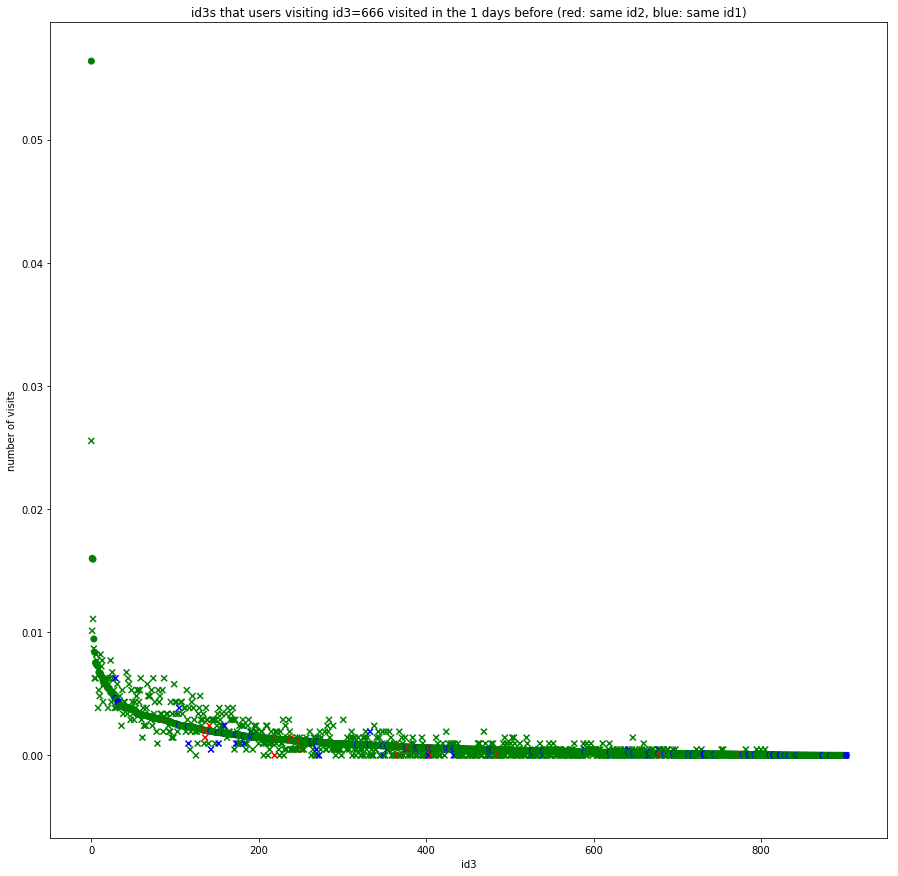

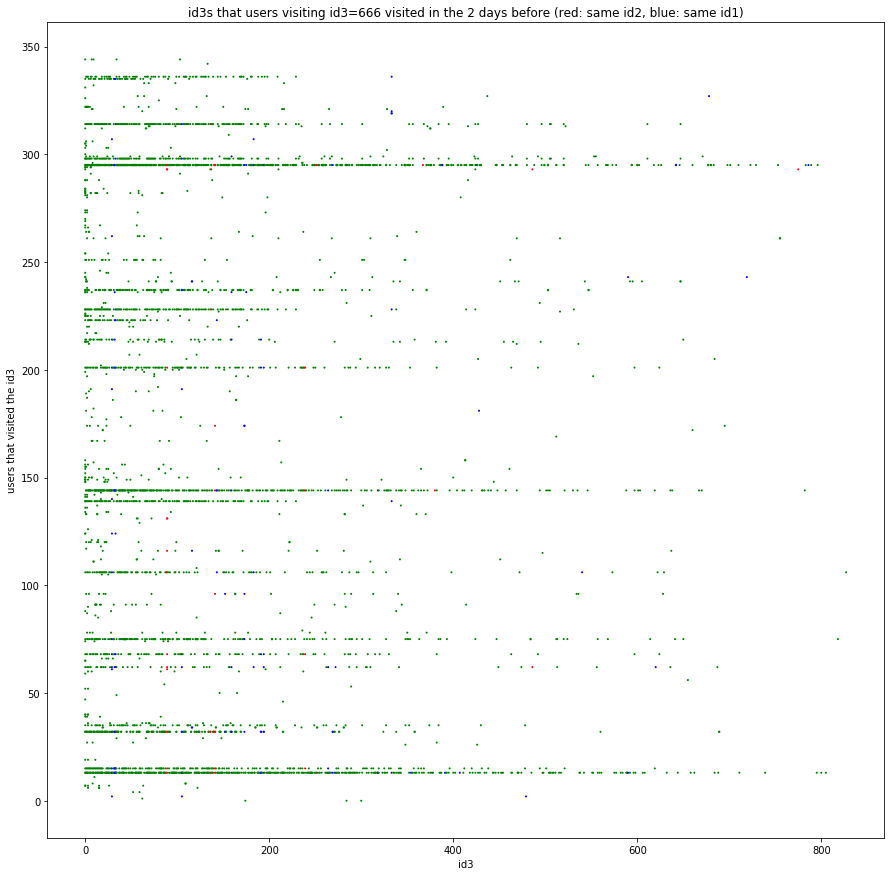

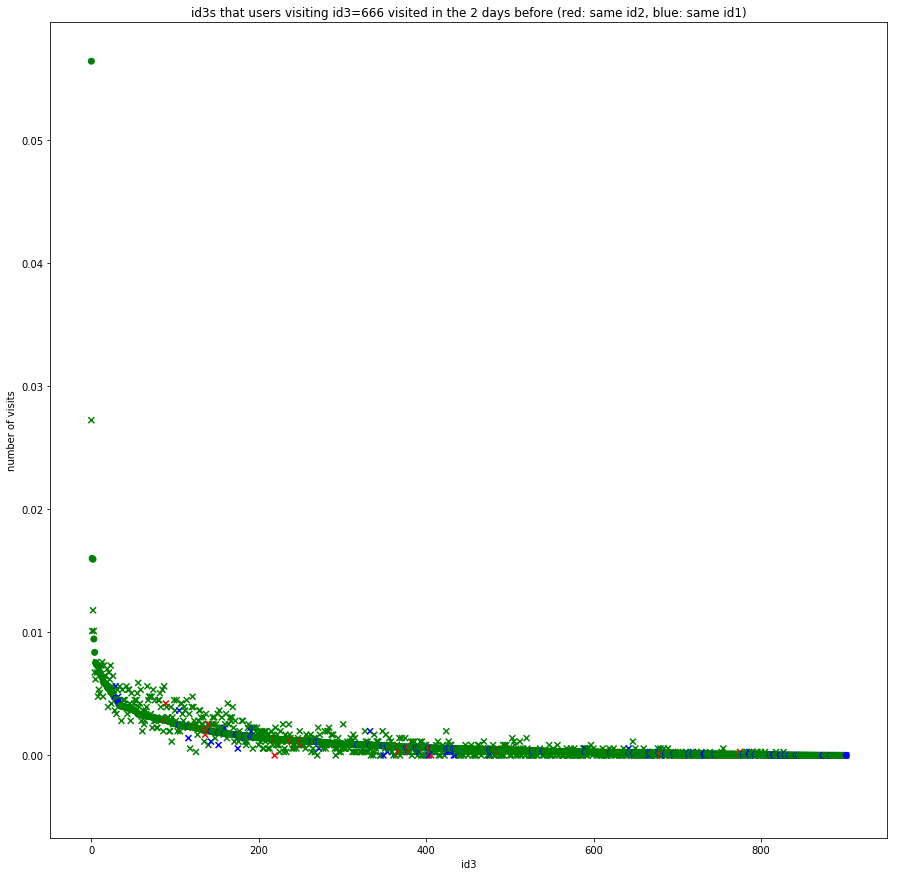

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 15)

for id3 in [42, 610, 666]:
    for duration in range(1, 3):
        X = []
        for user in id3ToUser[id3]:
            for day in range(minDayTrain, maxDayTrain + 1):
                if len(X) < 1000: #break when chart is full
                    if (user, day) in userId3Visits and id3 in userId3Visits[(user, day)]:
                        if not any([(user, d) in userId3Visits and id3 in userId3Visits[(user, d)] for d in range(max(0, day - 21), day)]):
                            X.append(profile(user, day, duration=duration))

        scatterx, scattery, scatters, scatterc = [], [], [], []
        for i in range(len(X)):
            for j in range(len(X[i])):
                if X[i][j]:
                    scatterx.append(j)
                    scattery.append(i)
                    scatters.append(1 * X[i][j])
                    id1Same = id21[id32[id3s[j]]] == id21[id32[id3]]
                    id2Same = id32[id3s[j]] == id32[id3]
                    if id2Same:
                        scatterc.append("r")
                    elif id1Same:
                        scatterc.append("b")
                    else:
                        scatterc.append("g")
        plt.scatter(scatterx, scattery, s=scatters, c=scatterc)
        plt.xlabel("id3")
        plt.ylabel("users that visited the id3")
        plt.title("id3s that users visiting id3={} visited in the {} days before (red: same id2, blue: same id1)".format(id3, duration))
        plt.show()

        totalVisits = [0 for _ in id3s]
        for i in range(len(X)):
            for j in range(len(X[i])):
                totalVisits[j] += X[i][j]
        sumTotalVisits = sum(totalVisits)
        totalVisits = [i/sumTotalVisits for i in totalVisits]

        sumAllVisits = sum(id3Visits.values())
        allVisits = [id3Visits[i]/sumAllVisits for i in id3s]

        visitsc = []
        for i in id3s:
            id1Same = id21[id32[i]] == id21[id32[id3]]
            id2Same = id32[i] == id32[id3]
            if id2Same:
                visitsc.append("r")
            elif id1Same:
                visitsc.append("b")
            else:
                visitsc.append("g")


        plt.scatter([i for i in range(len(id3s))], totalVisits, c=visitsc, marker="x")
        plt.scatter([i for i in range(len(id3s))], allVisits, c=visitsc)
        plt.xlabel("id3")
        plt.ylabel("number of visits")
        plt.title("id3s that users visiting id3={} visited in the {} days before (red: same id2, blue: same id1)".format(id3, duration))
        plt.show()

## Predictions

In [25]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

for id3 in [42, 610, 666]:
    for duration in range(1, 5):
        #find samples
        X0, X1 = [], []
        for user in id3ToUser[id3]:
            for day in range(maxDayTrain, minDayTrain - 1, -1):
                if not any([(user, d) in userId3Visits and id3 in userId3Visits[(user, d)] for d in range(max(0, day - 21), day)]):
                    visited = (user, day) in userId3Visits and id3 in userId3Visits[(user, day)]
                    if visited and len(X1) < 10000:
                        X1.append(profile(user, day, duration=duration, sums=True))
                    elif len(X1) > len(X0):
                        X0.append(profile(user, day, duration=duration, sums=True))
                        
        #compute training set
        X = X0 + X1
        y = [0] * len(X0) + [1] * len(X1)
        for regressor in [SGDRegressor(max_iter=1000), RandomForestRegressor()]:
            regressor = regressor.fit(X, y)
            print(id3, duration, regressor, regressor.score(X, y), len(X0), len(X1))
            print(min(regressor.predict(X0)), max(regressor.predict(X0)), min(regressor.predict(X1)), max(regressor.predict(X1)))

42 1 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False) -2.5716256233252764e+21 286 286
-27135731847.88145 509270915084.37823 -17891206324.738316 143191583020.87747
42 1 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 0.2087910337070451 286 286
0.0 0.8166666666666667 0.17357142857142854 1.0
42 2 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learn

In [26]:
duration = 2

#find samples
X1 = {id3: [] for id3 in id3s}
for i, user in enumerate(userToId3):
    if i % 100 == 0: print("user {} of {}".format(i, len(userToId3)))
    for day in range(maxDayTrain, minDayTrain - 1, -1):
        prof = profile(user, day, duration=duration, sums=True)
        for id3 in id3s:
            if (user, day) in userId3Visits and id3 in userId3Visits[(user, day)]:
                if not any([(user, d) in userId3Visits and id3 in userId3Visits[(user, d)] for d in range(max(0, day - 21), day)]):
                    X1[id3].append(prof)

user 0 of 8451
user 100 of 8451
user 200 of 8451
user 300 of 8451
user 400 of 8451
user 500 of 8451
user 600 of 8451
user 700 of 8451
user 800 of 8451
user 900 of 8451
user 1000 of 8451
user 1100 of 8451
user 1200 of 8451
user 1300 of 8451
user 1400 of 8451
user 1500 of 8451
user 1600 of 8451
user 1700 of 8451
user 1800 of 8451
user 1900 of 8451
user 2000 of 8451
user 2100 of 8451
user 2200 of 8451
user 2300 of 8451
user 2400 of 8451
user 2500 of 8451
user 2600 of 8451
user 2700 of 8451
user 2800 of 8451
user 2900 of 8451
user 3000 of 8451
user 3100 of 8451
user 3200 of 8451
user 3300 of 8451
user 3400 of 8451
user 3500 of 8451
user 3600 of 8451
user 3700 of 8451
user 3800 of 8451
user 3900 of 8451
user 4000 of 8451
user 4100 of 8451
user 4200 of 8451
user 4300 of 8451
user 4400 of 8451
user 4500 of 8451
user 4600 of 8451
user 4700 of 8451
user 4800 of 8451
user 4900 of 8451
user 5000 of 8451
user 5100 of 8451
user 5200 of 8451
user 5300 of 8451
user 5400 of 8451
user 5500 of 8451
user

In [27]:
from random import shuffle

X0 = {}
for i, id3 in enumerate(id3s):
    if i % 100 == 0: print("id3 {} of {}".format(i, len(id3s)))
    rows = sum([X1[i] for i in id3s if not i == id3], [])
    shuffle(rows)
    X0[id3] = rows[:len(X1[id3])]

id3 0 of 903
id3 100 of 903
id3 200 of 903
id3 300 of 903
id3 400 of 903
id3 500 of 903
id3 600 of 903
id3 700 of 903
id3 800 of 903
id3 900 of 903


In [28]:
#create regressors
regressors = {}
for i, id3 in enumerate(id3s):
    if i % 100 == 0: print("regressor {} of {}".format(i, len(id3s)))
    if len(X0[id3]) > 0 and len(X1[id3]) > 0:
        regressors[id3] = RandomForestRegressor().fit(X0[id3] + X1[id3], [0] * len(X0[id3]) + [1] * len(X1[id3])) 

regressor 0 of 903
regressor 100 of 903
regressor 200 of 903
regressor 300 of 903
regressor 400 of 903
regressor 500 of 903
regressor 600 of 903
regressor 700 of 903
regressor 800 of 903
regressor 900 of 903


In [29]:
#predictions
predictions = {user: {} for user in userToId3}
for i, user in enumerate(userToId3):
    if i % 100 == 0: print("user {} of {}".format(i, len(userToId3)))
    prof = profile(user, maxDayTrain, duration=duration, sums=True)
    for id3, regressor in regressors.items():
        predictions[user][id3] = regressor.predict([prof])[0]

user 0 of 8451
user 100 of 8451
user 200 of 8451
user 300 of 8451
user 400 of 8451
user 500 of 8451
user 600 of 8451
user 700 of 8451
user 800 of 8451
user 900 of 8451
user 1000 of 8451
user 1100 of 8451
user 1200 of 8451
user 1300 of 8451
user 1400 of 8451
user 1500 of 8451
user 1600 of 8451
user 1700 of 8451
user 1800 of 8451
user 1900 of 8451
user 2000 of 8451
user 2100 of 8451
user 2200 of 8451
user 2300 of 8451
user 2400 of 8451
user 2500 of 8451
user 2600 of 8451
user 2700 of 8451
user 2800 of 8451
user 2900 of 8451
user 3000 of 8451
user 3100 of 8451
user 3200 of 8451
user 3300 of 8451
user 3400 of 8451
user 3500 of 8451
user 3600 of 8451
user 3700 of 8451
user 3800 of 8451
user 3900 of 8451
user 4000 of 8451
user 4100 of 8451
user 4200 of 8451
user 4300 of 8451
user 4400 of 8451
user 4500 of 8451
user 4600 of 8451
user 4700 of 8451
user 4800 of 8451
user 4900 of 8451
user 5000 of 8451
user 5100 of 8451
user 5200 of 8451
user 5300 of 8451
user 5400 of 8451
user 5500 of 8451
user

In [39]:
#sum up
topCount = len(predictions) // 20
regressorScores = {id3: regressors[id3].score(X0[id3] + X1[id3], [0] * len(X0[id3]) + [1] * len(X1[id3])) for id3 in id3s}
predictedId3s = {user: sorted(predictions[user].keys(), key=lambda id3: -predictions[user][id3])[:5] for user in userToId3}
certainty = {user: sum([predictions[user][id3] for id3 in predictedId3s[user]]) for user in userToId3}
topUsers = sorted(userToId3.keys(), key=lambda user: -certainty[user])[:topCount]

In [40]:
#create df
dfData = {"user_id": topUsers}
for i in range(5):
    dfData["id3_{}".format(i+1)] = [predictedId3s[user][i] for user in topUsers]
pred = pd.DataFrame(data=dfData)
print(pred)

     id3_1  id3_2  id3_3  id3_4  id3_5  user_id
0       33     45     78    124    159        0
1      113    134    368    439    452        3
2        0    121    163    252    439        9
3        4      7     18     27     43       13
4       18     56    162    185    193       27
5       38     65     78     90    121       30
6       52    113    114    136    152       35
7       25     74     80    113    143       38
8       13    113    368    439    452       39
9        4      7     18     27     43       40
10      13     18     31    116    193       51
11      18     43     79    115    116       61
12      43    118    174    319    349       70
13      12     18     38     42     98       75
14       4      7     18     27     43       82
15      13    113    247    368    439       92
16      13     51     56    113    136       93
17      12     13     18     31     49       95
18      12     13     18     31     32      113
19      13     49    174    215    264  

In [41]:
score = 0
for i, row in pred.iterrows():
    hit = False
    for id3 in [row["id3_{}".format(i)] for i in range(1, 6)]:
        if ((test["user_id"] == row["user_id"]) & (test["id3"] == id3)).any():
            hit = True
    if hit:
        score += 1
print("{} of {} correct".format(score, pred["user_id"].count()))
score = (score / pred["user_id"].count()) * 10000
print("score {}".format(score))

9 of 422 correct
score 213.2701421800948
